In [1]:
import gymnasium as gym
import numpy as np
import traci
import sumolib
import os
import time
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.nn.utils as nn_utils
import matplotlib.pyplot as plt
import math
import random
from collections import namedtuple, deque
from tqdm import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device: {device}")

# Configurare Plotting
%matplotlib inline

Device: cuda


In [2]:
ENV_PATH = r"envs/double"
NET_FILE = os.path.join(ENV_PATH, "network.net.xml")
ROUTE_FILE = os.path.join(ENV_PATH, "flow.rou.xml")
# SEEDS = [36, 101, 999]
SEEDS = [36]

In [3]:
class SumoTrafficEnv(gym.Env):
    def __init__(self, mode='discrete', use_gui=False):
        super(SumoTrafficEnv, self).__init__()
        self.mode = mode
        self.use_gui = use_gui
        self.ts_id = None

        # Action Space: 4 faze
        self.action_space = gym.spaces.Discrete(4)

        # Observation Space, isi da update la reset
        self.observation_space = gym.spaces.Box(low=0, high=100, shape=(33,), dtype=np.float32)

        self.lanes = []

    def reset(self, seed=None):
        try:
            traci.close()
        except Exception:
            pass

        time.sleep(2.0)

        if self.use_gui:
            binary = sumolib.checkBinary('sumo-gui')
        else:
            binary = sumolib.checkBinary('sumo')

        cmd = [
            binary,
            "-n", NET_FILE,
            "-r", ROUTE_FILE,
            "--no-step-log", "true",
            "--waiting-time-memory", "1000",
            "--start",
            "--quit-on-end"
        ]

        try:
            traci.start(cmd)

            if self.ts_id is None:
                self.ts_id = traci.trafficlight.getIDList()[0]

            if not self.lanes:
                self.lanes = sorted(list(set(traci.trafficlight.getControlledLanes(self.ts_id))))
                # Actualizare dimensiune stare
                obs_dim = (len(self.lanes) * 2) + 1
                self.observation_space = gym.spaces.Box(low=0, high=100, shape=(obs_dim,), dtype=np.float32)

        except Exception as e:
            try: traci.close()
            except: pass
            raise e

        return self._get_state(), {}

    def step(self, action):
        target_phase = action * 2
        try:
            current_phase = traci.trafficlight.getPhase(self.ts_id)
            if current_phase != target_phase:
                yellow_phase = (current_phase + 1) % 8
                traci.trafficlight.setPhase(self.ts_id, yellow_phase)
                for _ in range(3): traci.simulationStep()
                traci.trafficlight.setPhase(self.ts_id, target_phase)

            reward = 0
            done = False
            for _ in range(5):
                traci.simulationStep()
                # Reward scalat pt stabilitate
                reward -= (self._get_total_waiting_time() / 100.0)
                if traci.simulation.getMinExpectedNumber() <= 0:
                    done = True
                    break
        except Exception:
            return np.zeros(self.observation_space.shape, dtype=np.float32), 0, True, False, {}

        return self._get_state(), reward, done, False, {}

    def _get_state(self):
        try:
            state = []
            for lane in self.lanes:
                state.append(traci.lane.getLastStepHaltingNumber(lane))
                state.append(traci.lane.getLastStepVehicleNumber(lane))
            phase = traci.trafficlight.getPhase(self.ts_id)
            state.append(phase)
            return np.array(state, dtype=np.float32)
        except:
            return np.zeros(self.observation_space.shape, dtype=np.float32)

    def _get_total_waiting_time(self):
        try:
            return sum([traci.lane.getWaitingTime(lane) for lane in self.lanes])
        except:
            return 0

    def close(self):
        try:
            traci.close()
        except:
            pass


In [4]:
class ReplayBuffer:
    def __init__(self, capacity):
        self.buffer = deque(maxlen=capacity)

    def push(self, state, action, reward, next_state, done):
        self.buffer.append((state, action, reward, next_state, done))

    def sample(self, batch_size):
        batch = random.sample(self.buffer, batch_size)
        state, action, reward, next_state, done = zip(*batch)
        return np.array(state), np.array(action), np.array(reward), np.array(next_state), np.array(done)

    def __len__(self):
        return len(self.buffer)

# **Deep SARSA**

In [5]:
class SARSANet(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(SARSANet, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, output_dim)
        )

    def forward(self, x):
        return self.fc(x)

In [6]:
class SARSAReplayBuffer:
    def __init__(self, capacity):
        self.buffer = deque(maxlen=capacity)

    def push(self, state, action, reward, next_state, next_action, done):
        self.buffer.append((state, action, reward, next_state, next_action, done))

    def sample(self, batch_size):
        batch = random.sample(self.buffer, batch_size)
        state, action, reward, next_state, next_action, done = zip(*batch)

        return (
            torch.tensor(np.array(state), dtype=torch.float32, device=device),
            torch.tensor(action, dtype=torch.int64, device=device).unsqueeze(1),
            torch.tensor(reward, dtype=torch.float32, device=device),
            torch.tensor(np.array(next_state), dtype=torch.float32, device=device),
            torch.tensor(next_action, dtype=torch.int64, device=device).unsqueeze(1),
            torch.tensor(done, dtype=torch.float32, device=device)
        )

    def __len__(self):
        return len(self.buffer)

In [7]:
class DeepSARSAAgent:
    def __init__(self, state_dim, action_dim, lr=1e-3, gamma=0.99, mem_size=50000, batch_size=32):
        self.gamma = gamma
        self.action_dim = action_dim
        self.batch_size = batch_size

        # Networks
        self.q_net = SARSANet(state_dim, action_dim).to(device)
        self.target_net = SARSANet(state_dim, action_dim).to(device)
        self.target_net.load_state_dict(self.q_net.state_dict())

        self.optimizer = optim.Adam(self.q_net.parameters(), lr=lr)
        self.loss_fn = nn.MSELoss()

        self.buffer = SARSAReplayBuffer(mem_size)

        # Epsilon params
        self.epsilon = 1.0
        self.epsilon_min = 0.02
        self.epsilon_decay = 0.995

    def select_action(self, state):
        if np.random.rand() < self.epsilon:
            return np.random.randint(self.action_dim)

        with torch.no_grad():
            if isinstance(state, np.ndarray):
                state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
            q_values = self.q_net(state)
            return q_values.argmax().item()

    def train_step(self):
        if len(self.buffer) < self.batch_size:
            return None

        states, actions, rewards, next_states, next_actions, dones = self.buffer.sample(self.batch_size)

        # Calculam Q(s, a) curent
        current_q = self.q_net(states).gather(1, actions).squeeze(1)

        # Calculam Target: R + gamma * Q_target(s', a')
        # Diferenta fata de DQN: Nu luam max(), ci luam q-value pentru next_action-ul stocat
        with torch.no_grad():
            next_q_val = self.target_net(next_states).gather(1, next_actions).squeeze(1)
            target_q = rewards + (1 - dones) * self.gamma * next_q_val

        loss = self.loss_fn(current_q, target_q)

        self.optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(self.q_net.parameters(), 5.0)
        self.optimizer.step()

        return loss.item()

    def update_target(self, tau=0.005):
        for t_param, o_param in zip(self.target_net.parameters(), self.q_net.parameters()):
            t_param.data.copy_(tau * o_param.data + (1.0 - tau) * t_param.data)

In [8]:
NUM_EPISODES = 200
BATCH_SIZE = 64
LR = 1e-3
MEM_SIZE = 50000


Experiment 1/1 Seed: 101


Seed 101: 100%|██████████| 200/200 [20:52<00:00,  6.26s/ep, Ret=-157.3, Eps=0.37, Loss=47.2750] 


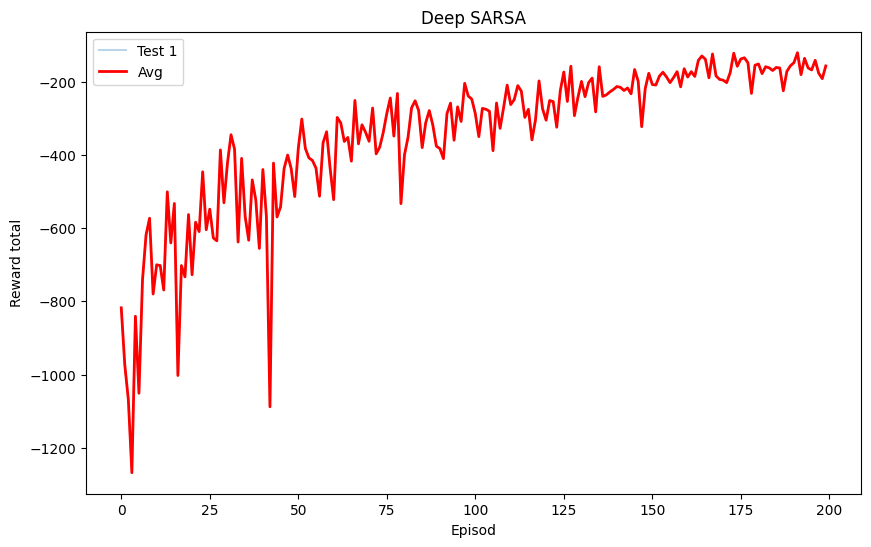

In [16]:
experiments_deep_sarsa = []

for run_idx, seed in enumerate(SEEDS):
    print(f"\nExperiment {run_idx + 1}/{len(SEEDS)} Seed: {seed}")

    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)

    try:
        traci.close()
    except:
        pass
    time.sleep(1)

    env = SumoTrafficEnv(use_gui=False)

    try:
        state, _ = env.reset()
    except:
        time.sleep(1)
        state, _ = env.reset()

    state_dim = env.observation_space.shape[0]
    action_dim = env.action_space.n

    agent = DeepSARSAAgent(state_dim, action_dim, lr=LR, mem_size=MEM_SIZE, batch_size=BATCH_SIZE)

    episode_returns = []

    pbar = tqdm(range(NUM_EPISODES), desc=f"Seed {seed}", unit="ep")

    for episode in pbar:
        state, _ = env.reset()
        ep_reward = 0
        last_loss = None

        action = agent.select_action(state)

        for step in range(200):
            next_state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated
            ep_reward += reward

            if done:
                next_action = 0
            else:
                next_action = agent.select_action(next_state)

            # Stocam (S, A, R, S', A')
            agent.buffer.push(state, action, reward, next_state, next_action, done)

            # Train
            loss = agent.train_step()
            if loss is not None:
                last_loss = loss
                agent.update_target()

            state = next_state
            action = next_action # Trecem la pasul urmator

            if done:
                break

        agent.epsilon = max(agent.epsilon_min, agent.epsilon * agent.epsilon_decay)
        episode_returns.append(ep_reward)

        loss_str = f"{last_loss:.4f}" if last_loss is not None else "_"
        pbar.set_postfix({"Ret": f"{ep_reward:.1f}", "Eps": f"{agent.epsilon:.2f}", "Loss": loss_str})

    env.close()
    experiments_deep_sarsa.append(episode_returns)

    torch.save(agent.q_net.state_dict(), f"sarsa/deep_sarsa_model_seed_{seed}.pth")

plt.figure(figsize=(10, 6))
for i, exp_data in enumerate(experiments_deep_sarsa):
    plt.plot(exp_data, alpha=0.3, label=f'Test {i+1}')

if experiments_deep_sarsa:
    min_len = min([len(x) for x in experiments_deep_sarsa])
    mean_sarsa = np.mean([x[:min_len] for x in experiments_deep_sarsa], axis=0)
    plt.plot(mean_sarsa, color='red', linewidth=2, label='Avg')

plt.title('Deep SARSA')
plt.xlabel('Episod')
plt.ylabel('Reward total')
plt.legend()
plt.show()

# **DQN**

In [9]:
Transition = namedtuple('Transition', ('state', 'action', 'next_state', 'reward'))

In [10]:
class ReplayMemory(object):
    def __init__(self, capacity):
        self.memory = deque([], maxlen = capacity)

    def push(self, *args):
        self.memory.append(Transition(*args))

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

In [11]:
class DQN(nn.Module):
    def __init__(self, n_states, n_actions):
        super().__init__()
        self.q_network = nn.Sequential(
            nn.Linear(n_states, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, n_actions),
        )

    def forward(self, x):
        return self.q_network(x)

In [12]:
class DQNAgent:
    def __init__(self, n_states, n_actions, lr=3e-4, mem_size=50000, batch_size=128, gamma=0.99):
        self.n_states = n_states
        self.n_actions = n_actions
        self.BATCH_SIZE = batch_size
        self.GAMMA = gamma

        # Policy & Target Networks
        self.policy_net = DQN(n_states, n_actions).to(device)
        self.target_net = DQN(n_states, n_actions).to(device)
        self.target_net.load_state_dict(self.policy_net.state_dict())

        self.optimizer = optim.AdamW(self.policy_net.parameters(), lr=lr, amsgrad=True)
        self.memory = ReplayMemory(mem_size)

        # Variabile pentru Epsilon Decay
        self.steps_done = 0
        self.EPS_START = 1.0
        self.EPS_END = 0.05
        self.EPS_DECAY = 2500

    def select_action(self, state, env):
        sample = random.random()
        eps_threshold = self.EPS_END + (self.EPS_START - self.EPS_END) * math.exp(-1.0 * self.steps_done / self.EPS_DECAY)
        self.steps_done += 1

        if sample > eps_threshold:
            with torch.no_grad():
                # t.max(1) - max pe toate coloanele
                # apoi index-ul acelui max
                return self.policy_net(state).max(1).indices.view(1, 1)
        else:
            return torch.tensor([[env.action_space.sample()]], device=device, dtype=torch.long)

    def optimize_model(self):
        if len(self.memory) < self.BATCH_SIZE:
            return None

        transitions = self.memory.sample(self.BATCH_SIZE)
        batch = Transition(*zip(*transitions))

        # Masca pentru starile nefinale
        non_final_mask = torch.tensor(tuple(map(lambda s: s is not None, batch.next_state)), device=device, dtype=torch.bool)

        # Concatenare stari nefinale
        if non_final_mask.sum() > 0:
            non_final_next_states = torch.cat([s for s in batch.next_state if s is not None])
        else:
            non_final_next_states = torch.empty((0, self.n_states), device=device)

        state_batch = torch.cat(batch.state)
        action_batch = torch.cat(batch.action)
        reward_batch = torch.cat(batch.reward)

        # Q(s, a)
        state_action_values = self.policy_net(state_batch).gather(1, action_batch)

        # V(s') = max(Q(s', a'))
        next_state_values = torch.zeros(self.BATCH_SIZE, device=device)
        with torch.no_grad():
            if non_final_mask.sum() > 0:
                next_state_values[non_final_mask] = self.target_net(non_final_next_states).max(1).values

        # Bellman
        expected_state_action_values = (next_state_values * self.GAMMA) + reward_batch

        # Huber Loss
        criterion = nn.SmoothL1Loss()
        loss = criterion(state_action_values, expected_state_action_values.unsqueeze(1))

        self.optimizer.zero_grad()
        loss.backward()
        # Gradient Clipping
        torch.nn.utils.clip_grad_value_(self.policy_net.parameters(), 100)
        self.optimizer.step()

        return float(loss.item())

    # Soft Update Logic
    def soft_update_target(self, tau=0.005):
        target_net_state_dict = self.target_net.state_dict()
        policy_net_state_dict = self.policy_net.state_dict()

        for key in policy_net_state_dict:
            target_net_state_dict[key] = policy_net_state_dict[key] * tau + target_net_state_dict[key] * (1-tau)
        self.target_net.load_state_dict(target_net_state_dict)

In [13]:
NUM_EPISODES = 200
TAU = 0.005
MAX_STEPS = 200
LR = 3e-4
MEM_SIZE = 50000
BATCH_SIZE = 32


Test1 Seed: 101


Seed 101: 100%|██████████| 200/200 [24:52<00:00,  7.46s/ep, Ret=-35.0, Loss=0.0993] 


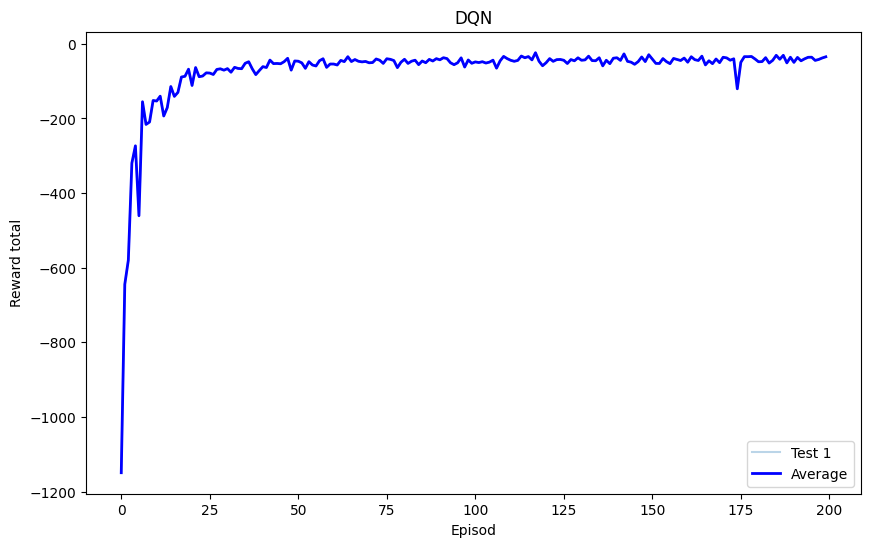

In [16]:
experiments_dqn = []

for i, seed in enumerate(SEEDS):
    print(f"\nTest{i+1} Seed: {seed}")

    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)

    env = SumoTrafficEnv(use_gui=False)

    try:
        state, _ = env.reset()
    except:
        time.sleep(1)
        state, _ = env.reset()

    n_obs = env.observation_space.shape[0]
    n_actions = env.action_space.n

    agent = DQNAgent(n_obs, n_actions, lr=LR, mem_size=MEM_SIZE, batch_size=BATCH_SIZE)

    episode_returns = []

    pbar = tqdm(range(NUM_EPISODES), desc=f"Seed {seed}", unit="ep")

    for episode in pbar:
        state, _ = env.reset()
        state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
        total_reward = 0.0
        last_loss = None

        done = False
        step = 0
        while not done and step < MAX_STEPS:
            action = agent.select_action(state, env)
            next_state_np, reward, terminated, truncated, _ = env.step(action.item())

            total_reward += float(reward)
            reward_t = torch.tensor([reward], device=device, dtype=torch.float32)
            done = terminated or truncated

            if done:
                next_state = None
            else:
                next_state = torch.tensor(next_state_np, dtype=torch.float32, device=device).unsqueeze(0)

            # Tinem minte tranzitia
            agent.memory.push(state, action, next_state, reward_t)

            # Urmatorul state
            state = next_state if next_state is not None else state

            # Train
            last_loss = agent.optimize_model()

            # Soft Update
            agent.soft_update_target(tau=TAU)

            if done:
                break
            step += 1

        episode_returns.append(total_reward)

        loss_str = f"{last_loss:.4f}" if last_loss is not None else "_"
        pbar.set_postfix({"Ret": f"{total_reward:.1f}", "Loss": loss_str})

    env.close()
    experiments_dqn.append(episode_returns)

    torch.save(agent.policy_net.state_dict(), f"dqn/dqn_model_seed_{seed}.pth")

plt.figure(figsize=(10, 6))
for i, exp_data in enumerate(experiments_dqn):
    plt.plot(exp_data, alpha=0.3, label=f'Test {i+1}')

min_len = min([len(x) for x in experiments_dqn])
mean_dqn = np.mean([x[:min_len] for x in experiments_dqn], axis=0)

plt.plot(mean_dqn, color='blue', linewidth=2, label='Average')
plt.title('DQN')
plt.xlabel('Episod')
plt.ylabel('Reward total')
plt.legend()
plt.show()

# **Double DQN**

In [14]:
# Folosim acelasi Transition si ReplayMemory din DQN
# Evident si acelasi network: DQN

In [15]:
class DoubleDQNAgent:
    def __init__(self, n_states, n_actions, lr=3e-4, mem_size=50000, batch_size=128, gamma=0.99):
        self.n_states = n_states
        self.n_actions = n_actions
        self.BATCH_SIZE = batch_size
        self.GAMMA = gamma

        # Policy & Target Networks
        self.policy_net = DQN(n_states, n_actions).to(device)
        self.target_net = DQN(n_states, n_actions).to(device)
        self.target_net.load_state_dict(self.policy_net.state_dict())

        self.optimizer = optim.AdamW(self.policy_net.parameters(), lr=lr, amsgrad=True)
        self.memory = ReplayMemory(mem_size)

        # Epsilon Params
        self.steps_done = 0
        self.EPS_START = 1.0
        self.EPS_END = 0.05
        self.EPS_DECAY = 2500

    def select_action(self, state, env):
        sample = random.random()
        eps_threshold = self.EPS_END + (self.EPS_START - self.EPS_END) * math.exp(-1.0 * self.steps_done / self.EPS_DECAY)
        self.steps_done += 1

        if sample > eps_threshold:
            with torch.no_grad():
                return self.policy_net(state).max(1).indices.view(1, 1)
        else:
            return torch.tensor([[env.action_space.sample()]], device=device, dtype=torch.long)

    def optimize_model(self):
        if len(self.memory) < self.BATCH_SIZE:
            return None

        transitions = self.memory.sample(self.BATCH_SIZE)
        batch = Transition(*zip(*transitions))

        non_final_mask = torch.tensor(tuple(map(lambda s: s is not None, batch.next_state)), device=device, dtype=torch.bool)

        if non_final_mask.sum() > 0:
            non_final_next_states = torch.cat([s for s in batch.next_state if s is not None])
        else:
            non_final_next_states = torch.empty((0, self.n_states), device=device)

        state_batch = torch.cat(batch.state)
        action_batch = torch.cat(batch.action)
        reward_batch = torch.cat(batch.reward)

        # Q(s, a) curent (estimat de Policy Net)
        state_action_values = self.policy_net(state_batch).gather(1, action_batch)

        # V(s') prin Double DQN
        # Decuplam selectia actiunii de evaluare
        next_state_values = torch.zeros(self.BATCH_SIZE, device=device)

        with torch.no_grad():
            if non_final_mask.sum() > 0:
                # Folosim policy net pentru a alege cea mai buna actiune pentru starea s'
                # argmax(Q_online(s', a'))
                best_actions_online = self.policy_net(non_final_next_states).argmax(dim=1, keepdim=True)

                # Apoi ne folosim de target net pt a calcula valoarea actiunii respective
                # Q_target(s', action_from_online)
                next_state_values[non_final_mask] = self.target_net(non_final_next_states).gather(1, best_actions_online).squeeze(1)

        # Bellman
        expected_state_action_values = (next_state_values * self.GAMMA) + reward_batch

        # Loss & Backprop
        criterion = nn.SmoothL1Loss()
        loss = criterion(state_action_values, expected_state_action_values.unsqueeze(1))

        self.optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_value_(self.policy_net.parameters(), 100)
        self.optimizer.step()

        return float(loss.item())

    def soft_update_target(self, tau=0.005):
        target_net_state_dict = self.target_net.state_dict()
        policy_net_state_dict = self.policy_net.state_dict()
        for key in policy_net_state_dict:
            target_net_state_dict[key] = policy_net_state_dict[key] * tau + target_net_state_dict[key] * (1-tau)
        self.target_net.load_state_dict(target_net_state_dict)

    def get_epsilon(self):
        return self.EPS_END + (self.EPS_START - self.EPS_END) * math.exp(-1.0 * self.steps_done / self.EPS_DECAY)

In [16]:
NUM_EPISODES = 200
MAX_STEPS = 200
TAU = 0.005
LR = 3e-4
MEM_SIZE = 50000
BATCH_SIZE = 32


Experiment 1/1 Seed: 36


Seed 36: 100%|██████████| 200/200 [32:29<00:00,  9.75s/ep, Ret=-45.4, Eps=0.050, Loss=0.2140]


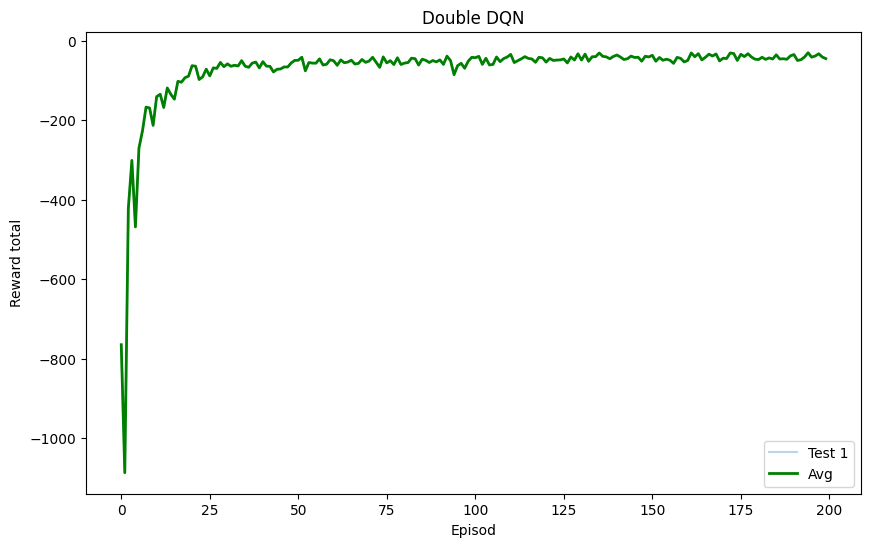

In [44]:
experiments_double_dqn = []

for run_idx, seed in enumerate(SEEDS):
    print(f"\nExperiment {run_idx + 1}/{len(SEEDS)} Seed: {seed}")

    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)

    env = SumoTrafficEnv(use_gui=False)
    
    try:
        state, _ = env.reset()
    except: 
        time.sleep(1)
        state, _ = env.reset()
        
    n_obs = env.observation_space.shape[0]
    n_actions = env.action_space.n
    
    agent = DoubleDQNAgent(n_obs, n_actions, lr=LR, mem_size=MEM_SIZE, batch_size=BATCH_SIZE)
    
    episode_returns = []

    pbar = tqdm(range(NUM_EPISODES), desc=f"Seed {seed}", unit="ep")
    
    for episode in pbar:
        state, _ = env.reset()
        state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
        total_reward = 0.0
        last_loss = None
        
        for step in range(MAX_STEPS):
            action = agent.select_action(state, env)
            next_state_np, reward, terminated, truncated, _ = env.step(action.item())
            
            total_reward += float(reward)
            reward_t = torch.tensor([reward], device=device, dtype=torch.float32)
            done = terminated or truncated
            
            if done:
                next_state = None
            else:
                next_state = torch.tensor(next_state_np, dtype=torch.float32, device=device).unsqueeze(0)

            agent.memory.push(state, action, next_state, reward_t)
            state = next_state if next_state is not None else state
            
            last_loss = agent.optimize_model()
            agent.soft_update_target(tau=TAU)
            
            if done:
                break
            
        episode_returns.append(total_reward)
        
        eps_curr = agent.get_epsilon()
        loss_str = f"{last_loss:.4f}" if last_loss is not None else "_"
        pbar.set_postfix({"Ret": f"{total_reward:.1f}", "Eps": f"{eps_curr:.3f}", "Loss": loss_str})

    env.close()
    experiments_double_dqn.append(episode_returns)

    torch.save(agent.policy_net.state_dict(), f"ddqn/double_dqn_model_seed_{seed}.pth")

plt.figure(figsize=(10, 6))
for i, exp_data in enumerate(experiments_double_dqn):
    plt.plot(exp_data, alpha=0.3, label=f'Test {i+1}')

if experiments_double_dqn:
    min_len = min([len(x) for x in experiments_double_dqn])
    mean_ddqn = np.mean([x[:min_len] for x in experiments_double_dqn], axis=0)
    plt.plot(mean_ddqn, color='green', linewidth=2, label='Avg')

plt.title('Double DQN')
plt.xlabel('Episod')
plt.ylabel('Reward total')
plt.legend()
plt.show()

# **Multi Step DQN**

In [17]:
class MultiStepReplayBuffer:
    def __init__(self, capacity, state_dim, n_step=3, gamma=0.99):
        self.capacity = capacity
        self.ptr = 0
        self.full = False

        self.states = np.zeros((capacity, state_dim), dtype=np.float32)
        self.next_states = np.zeros((capacity, state_dim), dtype=np.float32)
        self.actions = np.zeros(capacity, dtype=np.int64)
        self.rewards = np.zeros(capacity, dtype=np.float32)
        self.dones = np.zeros(capacity, dtype=np.float32)

        self.n_step = n_step
        self.gamma = gamma
        self.n_step_buffer = deque(maxlen=n_step)

    def store(self, s, s2, a, r, d):
        self.n_step_buffer.append((s, s2, a, r, d))

        # n pasi sau done
        if len(self.n_step_buffer) < self.n_step:
            return

        # N-Step Return
        R = 0
        discount = 1
        for (_, _, _, reward_i, done_i) in self.n_step_buffer:
            R += reward_i * discount
            discount *= self.gamma
            if done_i:
                break

        # peste n pasi luam starea initiala si starea finala
        s_0, _, a_0, _, _ = self.n_step_buffer[0]
        _, s_n, _, _, d_n = self.n_step_buffer[-1]

        idx = self.ptr
        self.states[idx] = s_0
        self.next_states[idx] = s_n
        self.actions[idx] = a_0
        self.rewards[idx] = R
        self.dones[idx] = float(d_n)

        self.ptr = (self.ptr + 1) % self.capacity
        if self.ptr == 0:
            self.full = True

    def finish_episode(self):
        while len(self.n_step_buffer) > 0:
            R = 0
            discount = 1
            for (_, _, _, reward_i, done_i) in self.n_step_buffer:
                R += reward_i * discount
                discount *= self.gamma
                if done_i: break

            s_0, _, a_0, _, _ = self.n_step_buffer[0]
            _, s_n, _, _, d_n = self.n_step_buffer[-1]

            idx = self.ptr
            self.states[idx] = s_0
            self.next_states[idx] = s_n
            self.actions[idx] = a_0
            self.rewards[idx] = R
            self.dones[idx] = float(d_n)

            self.ptr = (self.ptr + 1) % self.capacity
            if self.ptr == 0: self.full = True

            self.n_step_buffer.popleft()

    def sample(self, batch_size):
        max_size = self.capacity if self.full else self.ptr
        idx = np.random.choice(max_size, batch_size, replace=False)

        return (
            torch.tensor(self.states[idx], device=device),
            torch.tensor(self.next_states[idx], device=device),
            torch.tensor(self.actions[idx], device=device),
            torch.tensor(self.rewards[idx], device=device),
            torch.tensor(self.dones[idx], device=device)
        )

In [18]:
class MultiStepQNet(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(MultiStepQNet, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, output_dim)
        )

    def forward(self, x):
        return self.fc(x)

In [19]:
class MultiStepAgent:
    def __init__(self, state_dim, action_dim, lr=1e-3, gamma=0.99, n_step=3, mem_size=50000, batch_size=32):
        self.gamma = gamma
        self.n_step = n_step
        self.gamma_n = gamma ** n_step # Gamma la puterea N pentru update
        self.action_dim = action_dim
        self.batch_size = batch_size

        # Networks
        self.online = MultiStepQNet(state_dim, action_dim).to(device)
        self.target = MultiStepQNet(state_dim, action_dim).to(device)
        self.target.load_state_dict(self.online.state_dict())

        self.optimizer = optim.Adam(self.online.parameters(), lr=lr)
        self.loss_fn = nn.MSELoss()

        self.buffer = MultiStepReplayBuffer(mem_size, state_dim, n_step=n_step, gamma=gamma)

        # Epsilon
        self.epsilon = 1.0
        self.epsilon_min = 0.02
        self.epsilon_decay = 0.995

    def select_action(self, state):
        if np.random.rand() < self.epsilon:
            return np.random.randint(self.action_dim)

        with torch.no_grad():
            if isinstance(state, np.ndarray):
                state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
            q_values = self.online(state)
            return q_values.argmax().item()

    def train_step(self):
        # Asteptam sa se umple putin bufferul
        if self.buffer.ptr < self.batch_size and not self.buffer.full:
            return None

        states, next_states, actions, rewards, dones = self.buffer.sample(self.batch_size)

        # Double DQN Logic pentru N-Step
        with torch.no_grad():
            # Select action: Online Net
            next_actions = self.online(next_states).argmax(dim=1, keepdim=True)
            # Evaluate: Target Net
            next_q = self.target(next_states).gather(1, next_actions).squeeze(1)

            # Target: R + gamma^N * Q_target(s_n, argmax Q_online(s_n))
            target_q = rewards + (1 - dones) * self.gamma_n * next_q

        # Current Q
        current_q = self.online(states).gather(1, actions.unsqueeze(1)).squeeze(1)

        loss = self.loss_fn(current_q, target_q)

        self.optimizer.zero_grad()
        loss.backward()
        # Clipping gradient
        torch.nn.utils.clip_grad_norm_(self.online.parameters(), 5.0)
        self.optimizer.step()

        return loss.item()

    def soft_update(self, tau=0.005):
        for t_param, o_param in zip(self.target.parameters(), self.online.parameters()):
            t_param.data.copy_(tau * o_param.data + (1.0 - tau) * t_param.data)

In [20]:
NUM_EPISODES = 200
N_STEP = 3
LR = 1e-3
BATCH = 32
MEM_SIZE = 50000
TAU = 0.005


Experiment 1/1 Seed: 101


Seed 101: 100%|██████████| 200/200 [35:09<00:00, 10.55s/ep, Ret=-189.2, Eps=0.37, Loss=74.5817] 


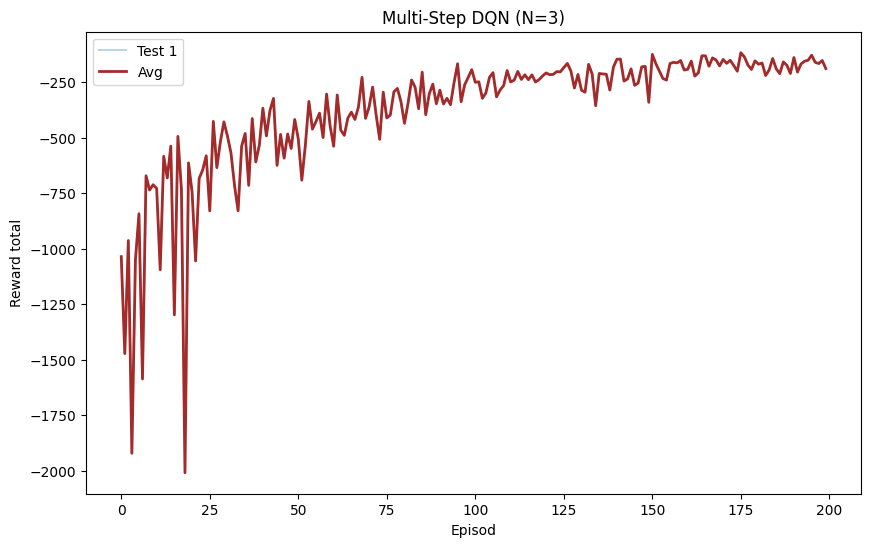

In [11]:
experiments_multistep = []

for run_idx, seed in enumerate(SEEDS):
    print(f"\nExperiment {run_idx + 1}/{len(SEEDS)} Seed: {seed}")

    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)

    try:
        traci.close()
    except:
        pass
    time.sleep(1)

    env = SumoTrafficEnv(use_gui=False)

    try:
        state, _ = env.reset()
    except:
        time.sleep(1)
        state, _ = env.reset()

    state_dim = env.observation_space.shape[0]
    action_dim = env.action_space.n

    agent = MultiStepAgent(state_dim, action_dim, lr=LR, n_step=N_STEP, mem_size=MEM_SIZE, batch_size=BATCH)

    episode_returns = []

    pbar = tqdm(range(NUM_EPISODES), desc=f"Seed {seed}", unit="ep")

    for episode in pbar:
        state, _ = env.reset()
        ep_reward = 0
        last_loss = None

        for step in range(200):
            action = agent.select_action(state)

            next_state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated
            ep_reward += reward

            # N-step buffer
            agent.buffer.store(state, next_state, action, reward, done)
            state = next_state

            loss = agent.train_step()
            if loss is not None:
                last_loss = loss
                agent.soft_update(tau=TAU)

            if done:
                break

        # Golim bufferul temporar la final de episod
        agent.buffer.finish_episode()

        # Decay pt Epsilon
        agent.epsilon = max(agent.epsilon_min, agent.epsilon * agent.epsilon_decay)
        episode_returns.append(ep_reward)

        loss_str = f"{last_loss:.4f}" if last_loss is not None else "_"
        pbar.set_postfix({"Ret": f"{ep_reward:.1f}", "Eps": f"{agent.epsilon:.2f}", "Loss": loss_str})

    env.close()
    experiments_multistep.append(episode_returns)

    torch.save(agent.online.state_dict(), f"msdqn/multistep_model_seed_{seed}.pth")

plt.figure(figsize=(10, 6))
for i, exp_data in enumerate(experiments_multistep):
    plt.plot(exp_data, alpha=0.3, label=f'Test {i+1}')

if experiments_multistep:
    min_len = min([len(x) for x in experiments_multistep])
    mean_res = np.mean([x[:min_len] for x in experiments_multistep], axis=0)
    plt.plot(mean_res, color='brown', linewidth=2, label='Avg')

plt.title(f'Multi-Step DQN (N={N_STEP})')
plt.xlabel('Episod')
plt.ylabel('Reward total')
plt.legend()
plt.show()

# **Dueling Double DQN**

In [21]:
class DuelingReplayBuffer:
    def __init__(self, size, state_dim):
        self.mem_size = size
        self.mem_cnt = 0
        self.state_memory = np.zeros((size, state_dim), dtype=np.float32)
        self.next_state_memory = np.zeros((size, state_dim), dtype=np.float32)
        self.action_memory = np.zeros(size, dtype=np.int32)
        self.reward_memory = np.zeros(size, dtype=np.float32)

    def store(self, state, next_state, action, reward):
        idx = self.mem_cnt % self.mem_size
        self.state_memory[idx] = state
        self.next_state_memory[idx] = next_state
        self.action_memory[idx] = action
        self.reward_memory[idx] = reward
        self.mem_cnt += 1

    def sample(self, batch_size):
        max_mem = min(self.mem_cnt, self.mem_size)
        batch = np.random.choice(max_mem, batch_size, replace=False)

        return (
            torch.tensor(self.state_memory[batch], dtype=torch.float32).to(device),
            torch.tensor(self.next_state_memory[batch], dtype=torch.float32).to(device),
            torch.tensor(self.action_memory[batch], dtype=torch.int32).to(device),
            torch.tensor(self.reward_memory[batch], dtype=torch.float32).to(device),
        )

In [22]:
class DuelingQNetwork(nn.Module):
    def __init__(self, input_dim, n_actions):
        super().__init__()

        self.network = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU()
        )
        self.value = nn.Linear(128, 1)
        self.advantage = nn.Linear(128, n_actions)

    def forward(self, x):
        if not torch.is_tensor(x):
            x = torch.tensor(x, dtype=torch.float32).to(device)

        # Device corect
        if x.device != device:
            x = x.to(device)

        features = self.network(x)
        V = self.value(features)
        A = self.advantage(features)

        A_mean = A.mean(dim=1, keepdim=True)
        Q = V + (A - A_mean)

        return torch.clamp(Q, -100, 100)

    def act(self, obs):
        # Adaptare device
        obs = torch.tensor(obs, dtype=torch.float32).unsqueeze(0).to(device)
        with torch.no_grad():
            Q = self.forward(obs)
        return int(torch.argmax(Q, dim=1).item())

In [23]:
class DuelingDQNAgent:
    def __init__(self, state_dim, n_actions, lr=3e-4, mem_size=1000000, soft=0.01):
        self.online = DuelingQNetwork(state_dim, n_actions).to(device)
        self.target = DuelingQNetwork(state_dim, n_actions).to(device)
        self.target.load_state_dict(self.online.state_dict())

        self.optimizer = optim.Adam(self.online.parameters(), lr=lr)
        self.criterion = nn.MSELoss()
        self.buffer = DuelingReplayBuffer(mem_size, state_dim)

        self.state_dim = state_dim
        self.n_actions = n_actions
        self.SOFT = soft

        # Epsilon Params
        self.epsilon = 1.0 # INITIAL_EPS
        self.FINAL_EPS = 0.02
        self.EPS_DECAY = 0.995

    def soft_update(self):
        for target_param, online_param in zip(self.target.parameters(), self.online.parameters()):
            target_param.data.copy_(self.SOFT * online_param.data + (1.0 - self.SOFT) * target_param.data)

In [24]:
GAMMA = 0.99
LR = 3e-4
BATCH = 32
MEM_SIZE = 1000000
NUM_EPISODES = 200
SOFT = 0.01


Experiment 1/1 Seed: 101


Seed 101: 100%|██████████| 200/200 [20:07<00:00,  6.04s/ep, Ret=-111.4, Eps=0.367, Loss=2.8272] 


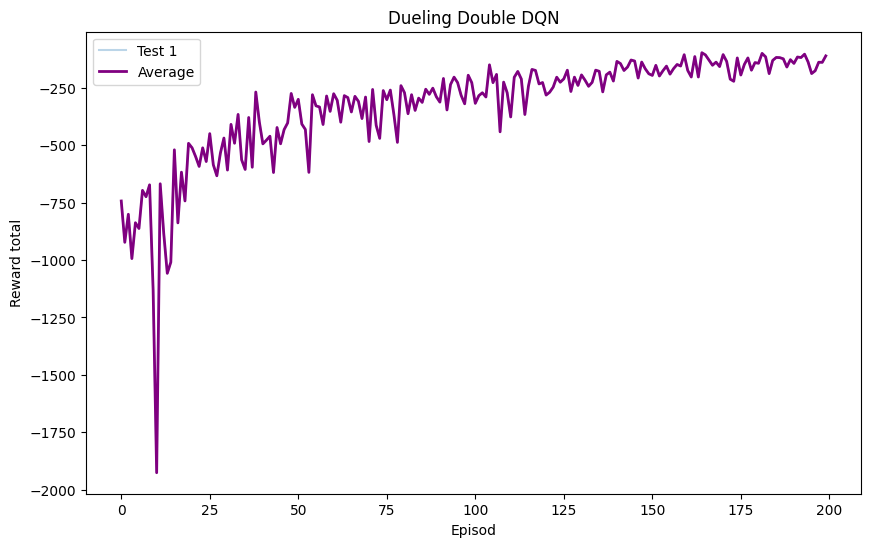

In [29]:
experiments_dueling = []

for run_idx, seed in enumerate(SEEDS):
    print(f"\nExperiment {run_idx + 1}/{len(SEEDS)} Seed: {seed}")

    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)

    env = SumoTrafficEnv(use_gui=False)

    try:
        state, _ = env.reset()
    except:
        time.sleep(1)
        state, _ = env.reset()

    state_dim = env.observation_space.shape[0]
    n_actions = env.action_space.n

    agent = DuelingDQNAgent(state_dim, n_actions, lr=LR, mem_size=MEM_SIZE, soft=SOFT)

    episode_returns = []

    pbar = tqdm(range(NUM_EPISODES), desc=f"Seed {seed}", unit="ep")

    for episode in pbar:
        state, _ = env.reset()
        ep_reward = 0
        last_loss = None

        for _ in range(200):
            if random.random() < agent.epsilon:
                action = env.action_space.sample()
            else:
                action = agent.online.act(state)

            # Step
            next_state, reward, terminated, truncated, _ = env.step(action)
            ep_reward += reward

            # Store
            agent.buffer.store(state, next_state, action, reward)
            state = next_state

            # Train step
            if agent.buffer.mem_cnt > 1000:
                states, next_states, actions, rewards = agent.buffer.sample(BATCH)

                actions = actions.long()

                with torch.no_grad():
                    # actiunea cu Online, evaluarea cu Target
                    next_actions = torch.argmax(agent.online(next_states), dim=1)
                    next_Q = agent.target(next_states).gather(1, next_actions.unsqueeze(1)).squeeze(1)
                    y = rewards + GAMMA * next_Q

                agent.optimizer.zero_grad()

                q_pred = agent.online(states)
                pred = q_pred.gather(1, actions.unsqueeze(1)).squeeze(1)

                loss = agent.criterion(pred, y)
                loss.backward()

                nn_utils.clip_grad_norm_(agent.online.parameters(), max_norm=5.0)
                agent.optimizer.step()

                # Soft update
                agent.soft_update()
                last_loss = loss.item()

        # Epsilon Decay
        agent.epsilon = max(agent.FINAL_EPS, agent.epsilon * agent.EPS_DECAY)
        episode_returns.append(ep_reward)

        loss_str = f"{last_loss:.4f}" if last_loss is not None else "_"
        pbar.set_postfix({"Ret": f"{ep_reward:.1f}", "Eps": f"{agent.epsilon:.3f}", "Loss": loss_str})

    env.close()
    experiments_dueling.append(episode_returns)

    torch.save(agent.online.state_dict(), f"dddqn/dddqn_model_seed_{seed}.pth")

plt.figure(figsize=(10, 6))
for i, exp_data in enumerate(experiments_dueling):
    plt.plot(exp_data, alpha=0.3, label=f'Test {i+1}')

if experiments_dueling:
    min_len = min([len(x) for x in experiments_dueling])
    mean_dueling = np.mean([x[:min_len] for x in experiments_dueling], axis=0)
    plt.plot(mean_dueling, color='purple', linewidth=2, label='Average')

plt.title('Dueling Double DQN')
plt.xlabel('Episod')
plt.ylabel('Reward total')
plt.legend()
plt.show()

# **Advantageous Actor Critic (A2C)**

In [25]:
class PolicyNet(nn.Module):
    def __init__(self, state_dim, action_dim):
        super().__init__()
        self.policy = nn.Sequential(
            nn.Linear(state_dim, 256),
            nn.ReLU(),
            nn.Linear(256, action_dim)
        )

    def forward(self, x):
        return self.policy(x)

class ValueNet(nn.Module):
    def __init__(self, state_dim):
        super().__init__()
        self.value = nn.Sequential(
            nn.Linear(state_dim, 256),
            nn.ReLU(),
            nn.Linear(256, 1)
        )

    def forward(self, x):
        return self.value(x)

In [26]:
class A2CAgent:
    def __init__(self, state_dim, action_dim, gamma=0.99, n_steps=5, lr=3e-4):
        self.gamma = gamma
        self.n_steps = n_steps

        self.policy = PolicyNet(state_dim, action_dim).to(device)
        self.value = ValueNet(state_dim).to(device)

        # Optimizator comun pentru ambele nn
        self.opt = optim.Adam(list(self.policy.parameters()) + list(self.value.parameters()), lr=lr)

    def act(self, state):
        # Convertim starea la tensor pe device
        s = torch.tensor(state, dtype=torch.float32).to(device)

        logits = self.policy(s)
        probs = F.softmax(logits, dim=-1)
        dist = torch.distributions.Categorical(probs)
        action = dist.sample()
        logp = dist.log_prob(action)

        value = self.value(s)

        return action.item(), logp, value

    def train_step(self, rewards, logps, values, next_state):
        next_state_t = torch.tensor(next_state, dtype=torch.float32).to(device)

        with torch.no_grad():
            next_value = self.value(next_state_t)

        # G (Returns)
        returns = []
        G = next_value

        for r, _ in zip(reversed(rewards), reversed(values)):
            G = r + self.gamma * G
            returns.insert(0, G)

        returns = torch.cat(returns)
        values_tensor = torch.cat(values)

        # Advantage = Returns - Baseline (Value)
        advantages = returns - values_tensor

        # Actor loss
        logp_tensor = torch.stack(logps)
        actor_loss = -(logp_tensor * advantages.detach()).mean()

        # Critic loss
        critic_loss = advantages.pow(2).mean()

        # Total loss
        loss = actor_loss + 0.5 * critic_loss

        self.opt.zero_grad()
        loss.backward()
        # Gradient Clipping
        nn.utils.clip_grad_norm_(list(self.policy.parameters()) + list(self.value.parameters()), 0.5)
        self.opt.step()

In [27]:
NUM_EPISODES = 60
STEPS_PER_EP = 250
GAMMA = 0.99
LR = 3e-4


Experiment 1/1 Seed: 101


Seed 101: 100%|██████████| 60/60 [09:08<00:00,  9.14s/ep, Ret=-61.7] 


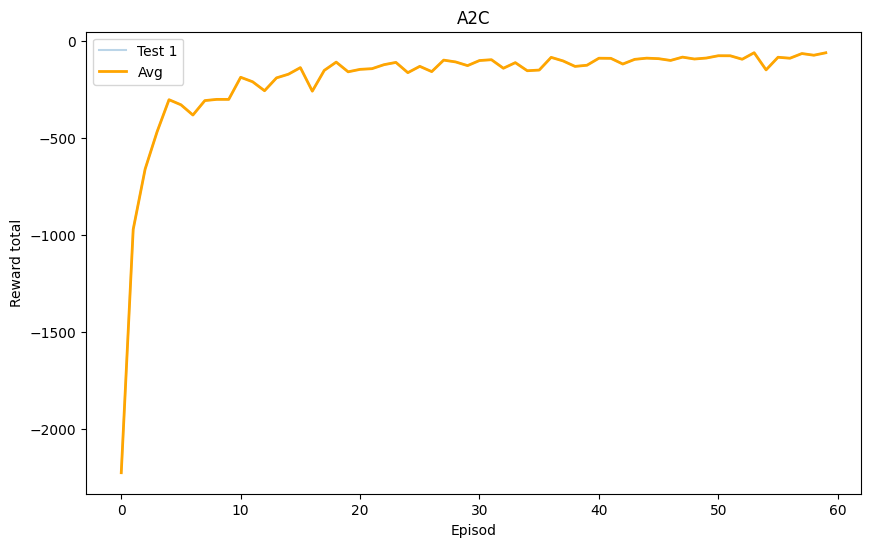

In [33]:
experiments_a2c = []

for run_idx, seed in enumerate(SEEDS):
    print(f"\nExperiment {run_idx + 1}/{len(SEEDS)} Seed: {seed}")

    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)

    env = SumoTrafficEnv(use_gui=False)

    try:
        state, _ = env.reset()
    except:
        time.sleep(1)
        state, _ = env.reset()

    state_dim = env.observation_space.shape[0]
    action_dim = env.action_space.n

    agent = A2CAgent(state_dim, action_dim, gamma=GAMMA, lr=LR)

    reward_history = []

    pbar = tqdm(range(NUM_EPISODES), desc=f"Seed {seed}", unit="ep")

    for ep in pbar:
        state, _ = env.reset()
        ep_reward = 0

        rewards, logps, values = [], [], []

        for _ in range(STEPS_PER_EP):
            action, logp, value = agent.act(state)
            next_state, reward, terminated, truncated, _ = env.step(action)

            rewards.append(reward)
            logps.append(logp)
            values.append(value)

            ep_reward += reward
            state = next_state

            # update la fiecare batch mic
            agent.train_step(rewards, logps, values, next_state)
            rewards, logps, values = [], [], [] # Clear

            if terminated or truncated:
                break

        reward_history.append(ep_reward)

        pbar.set_postfix({"Ret": f"{ep_reward:.1f}"})

    env.close()
    experiments_a2c.append(reward_history)

    torch.save(agent.policy.state_dict(), f"a2c/a2c_policy_seed_{seed}.pth")

plt.figure(figsize=(10, 6))
for i, exp_data in enumerate(experiments_a2c):
    plt.plot(exp_data, alpha=0.3, label=f'Test {i+1}')

if experiments_a2c:
    min_len = min([len(x) for x in experiments_a2c])
    mean_a2c = np.mean([x[:min_len] for x in experiments_a2c], axis=0)
    plt.plot(mean_a2c, color='orange', linewidth=2, label='Avg')

plt.title('A2C')
plt.xlabel('Episod')
plt.ylabel('Reward total')
plt.legend()
plt.show()

In [75]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def run_inference(model_type):
    print(f"\n{model_type}")
    print("Inferenta:")

    try:
        env_temp = SumoTrafficEnv(use_gui=False)
        try:
            state, _ = env_temp.reset()
        except:
            time.sleep(1)
            state, _ = env_temp.reset()

        state_dim = env_temp.observation_space.shape[0]
        action_dim = env_temp.action_space.n
        env_temp.close()
    except Exception as e:
        print(f"Eroare initializare env: {e}")
        return

    model = None
    max_steps = 200 # Default

    try:
        if model_type == "Deep SARSA":
            model = SARSANet(state_dim, action_dim).to(device)
            model.load_state_dict(torch.load("sarsa/deep_sarsa_model_seed_101.pth"))

        elif model_type == "DQN":
            model = DQN(state_dim, action_dim).to(device)
            model.load_state_dict(torch.load("dqn/dqn_model_seed_101.pth"))

        elif model_type == "Double DQN":
            model = DQN(state_dim, action_dim).to(device)
            model.load_state_dict(torch.load("ddqn/double_dqn_model_seed_101.pth"))

        elif model_type == "Multi Step DQN":
            model = MultiStepQNet(state_dim, action_dim).to(device)
            model.load_state_dict(torch.load("msdqn/multistep_model_seed_101.pth"))

        elif model_type == "Dueling Double DQN":
            model = DuelingQNetwork(state_dim, action_dim).to(device)
            model.load_state_dict(torch.load("dddqn/dddqn_model_seed_101.pth"))

        elif model_type == "A2C":
            model = PolicyNet(state_dim, action_dim).to(device)
            model.load_state_dict(torch.load("a2c/a2c_policy_seed_101.pth"))

        else:
            print("Model necunoscut.")
            return

    except Exception as e:
        print(f"Eroare incarcare model: {e}")
        return

    model.eval()
    print("Modelul a fost incarcat.")

    env = SumoTrafficEnv(use_gui=True)
    test_scores = []

    print(f"\nTest:")
    time.sleep(2)

    try:
        state, _ = env.reset()
    except:
        time.sleep(2)
        state, _ = env.reset()

    total_reward = 0.0
    done = False
    step = 0

    while not done and step < max_steps:

        with torch.no_grad():
            if model_type == "Deep SARSA":
                state_t = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
                action = model(state_t).argmax().item()

            elif model_type == "DQN" or model_type == "Double DQN":
                state_t = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
                action = model(state_t).max(1).indices.view(1, 1).item()

            elif model_type == "Multi Step DQN":
                state_t = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
                action = model(state_t).argmax().item()

            elif model_type == "Dueling Double DQN":
                # Dueling are metoda .act() interna
                action = model.act(state)

            elif model_type == "A2C":
                state_t = torch.tensor(state, dtype=torch.float32).to(device)
                logits = model(state_t)
                probs = torch.nn.functional.softmax(logits, dim=-1)
                action = torch.argmax(probs).item()

        next_state, reward, terminated, truncated, _ = env.step(action)
        done = terminated or truncated
        total_reward += reward
        state = next_state
        step += 1

    print(f"Test finalizat. Reward total: {total_reward:.2f}")
    test_scores.append(total_reward)

    env.close()
    print(f"\nInferenta completa. Avg score: {np.mean(test_scores):.2f}")

# run_inference("Deep SARSA") # Reward total: -80.90
# run_inference("DQN") # Reward total: -29.73
# run_inference("Double DQN") # Reward total: -38.06
# run_inference("Multi Step DQN") # Reward total: -97.85
# run_inference("Dueling Double DQN") # Reward total: -48.93
run_inference("A2C") # Reward total: -58.07


A2C
Inferenta:


D:\Temp\ipykernel_10768\350883001.py:48: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("a2c/a2c_policy_seed_101.pth"))


Modelul a fost incarcat.

Test:
Test finalizat. Reward total: -58.07

Inferenta completa. Avg score: -58.07


Deep SARSA... 

D:\Temp\ipykernel_10768\3429591397.py:32: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("sarsa/deep_sarsa_model_seed_101.pth"))


Final Reward: -80.90
DQN... 

D:\Temp\ipykernel_10768\3429591397.py:36: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("dqn/dqn_model_seed_101.pth"))


Final Reward: -29.73
Double DQN... 

D:\Temp\ipykernel_10768\3429591397.py:40: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("ddqn/double_dqn_model_seed_101.pth"))


Final Reward: -38.06
Multi Step DQN... 

D:\Temp\ipykernel_10768\3429591397.py:45: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("msdqn/multistep_model_seed_101.pth"))


Final Reward: -97.85
Dueling Double DQN... 

D:\Temp\ipykernel_10768\3429591397.py:49: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("dddqn/dddqn_model_seed_101.pth"))


Final Reward: -48.93
A2C... 

D:\Temp\ipykernel_10768\3429591397.py:54: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("a2c/a2c_policy_seed_101.pth"))


Final Reward: -58.07


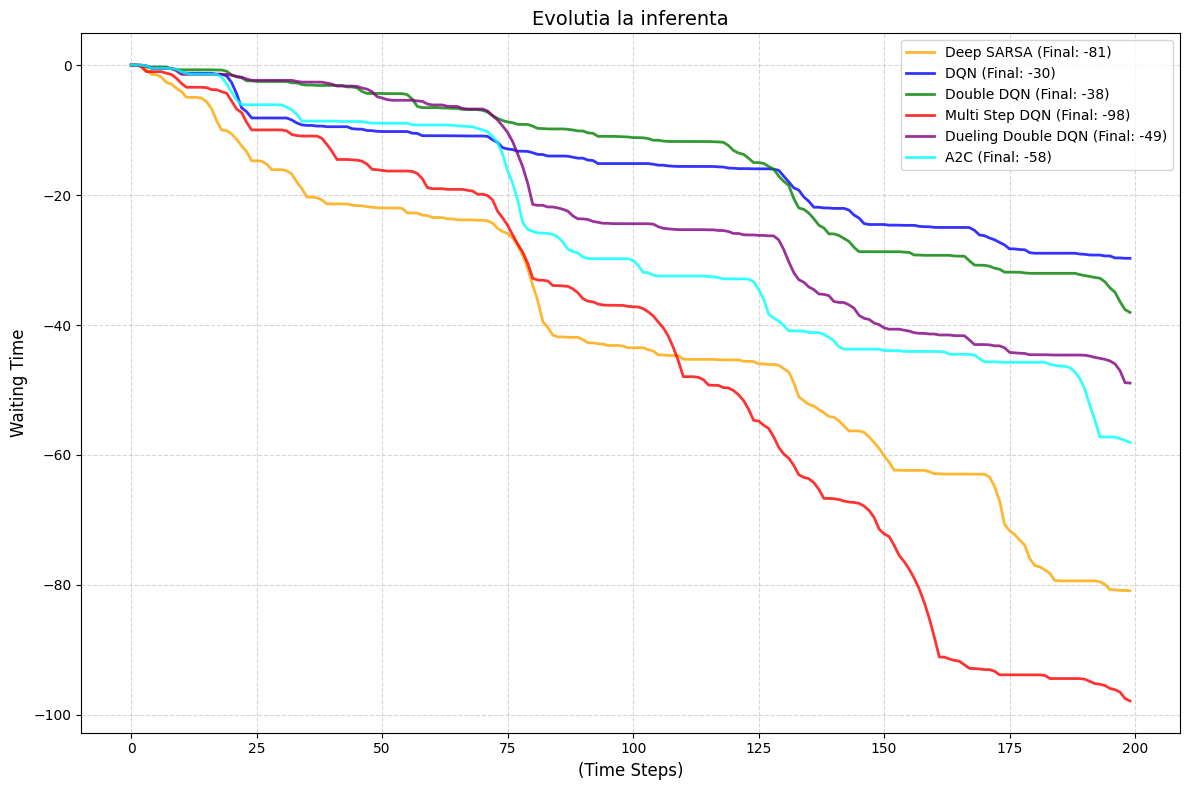

In [68]:
models_list = [
    "Deep SARSA",
    "DQN",
    "Double DQN",
    "Multi Step DQN",
    "Dueling Double DQN",
    "A2C"
]

results_history = {}
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

for model_type in models_list:
    print(f"{model_type}...", end=" ")

    try:
        env = SumoTrafficEnv(use_gui=False)
        try:
            state, _ = env.reset()
        except:
            time.sleep(0.5)
            state, _ = env.reset()

        state_dim = env.observation_space.shape[0]
        action_dim = env.action_space.n

        model = None
        max_steps = 200 # Limita pasi

        if model_type == "Deep SARSA":
            model = SARSANet(state_dim, action_dim).to(device)
            model.load_state_dict(torch.load("sarsa/deep_sarsa_model_seed_101.pth"))

        elif model_type == "DQN":
            model = DQN(state_dim, action_dim).to(device)
            model.load_state_dict(torch.load("dqn/dqn_model_seed_101.pth"))

        elif model_type == "Double DQN":
            model = DQN(state_dim, action_dim).to(device)
            model.load_state_dict(torch.load("ddqn/double_dqn_model_seed_101.pth"))

        elif model_type == "Multi Step DQN":
            model = MultiStepQNet(state_dim, action_dim).to(device)
            model.load_state_dict(torch.load("msdqn/multistep_model_seed_101.pth"))

        elif model_type == "Dueling Double DQN":
            model = DuelingQNetwork(state_dim, action_dim).to(device)
            model.load_state_dict(torch.load("dddqn/dddqn_model_seed_101.pth"))

        elif model_type == "A2C":
            model = PolicyNet(state_dim, action_dim).to(device)
            model.load_state_dict(torch.load("a2c/a2c_policy_seed_101.pth"))

        model.eval()

        total_reward = 0.0
        episode_history = [] # evolutia reward-ului
        done = False
        step = 0

        while not done and step < max_steps:
            with torch.no_grad():
                if model_type == "Deep SARSA":
                    state_t = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
                    action = model(state_t).argmax().item()

                elif model_type == "DQN" or model_type == "Double DQN":
                    state_t = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
                    action = model(state_t).max(1).indices.view(1, 1).item()

                elif model_type == "Multi Step DQN":
                    state_t = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
                    action = model(state_t).argmax().item()

                elif model_type == "Dueling Double DQN":
                    try:
                        action = model.act(state, device=device)
                    except:
                        action = model.act(state)

                elif model_type == "A2C":
                    state_t = torch.tensor(state, dtype=torch.float32).to(device)
                    logits = model(state_t)
                    probs = torch.nn.functional.softmax(logits, dim=-1)
                    action = torch.argmax(probs).item()

            next_state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated

            total_reward += reward
            episode_history.append(total_reward) # Salvam reward-ul cumulat la pasul curent

            state = next_state
            step += 1

        results_history[model_type] = episode_history
        print(f"Final Reward: {total_reward:.2f}")
        env.close()

    except Exception as e:
        print(f"FAILED: {e}")
        try:
            env.close()
        except: pass

plt.figure(figsize=(12, 8))

colors = {
    "Deep SARSA": 'orange',
    "DQN": 'blue',
    "Double DQN": 'green',
    "Multi Step DQN": 'red',
    "Dueling Double DQN": 'purple',
    "A2C": 'cyan'
}

for model_name, history in results_history.items():
    plt.plot(history, label=f"{model_name} (Final: {history[-1]:.0f})",
             color=colors.get(model_name, 'black'), linewidth=2, alpha=0.8)

plt.xlabel('(Time Steps)', fontsize=12)
plt.ylabel('Waiting Time', fontsize=12)
plt.title('Evolutia la inferenta', fontsize=14)
plt.legend(fontsize=10)
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

# **Un task bonus in care combinam CV cu RL**

Am simulat pana acum toti algoritmii intr-un environment care simuleaza ce s-ar intampla in realitate.

Ce ar fi daca am avea o intersectie reala in schimb?

Cum s-ar comporta algoritmii antrenati pe aceasta intersectie, avand in vedere ca a fost antrenat pe altceva?

Merge ideea de transfer control?

In [2]:
%pip install opencv-python
%pip install torchvision --index-url https://download.pytorch.org/whl/cu121

  Using cached opencv_python-4.12.0.88-cp37-abi3-win_amd64.whl.metadata (19 kB)
Using cached opencv_python-4.12.0.88-cp37-abi3-win_amd64.whl (39.0 MB)
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.1.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


Looking in indexes: https://download.pytorch.org/whl/cu121
  Using cached https://download.pytorch.org/whl/cu121/torchvision-0.20.1%2Bcu121-cp310-cp310-win_amd64.whl (6.1 MB)
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.1.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [28]:
import cv2
import subprocess
from torchvision.models.detection import maskrcnn_resnet50_fpn_v2, MaskRCNN_ResNet50_FPN_V2_Weights
from torchvision.transforms import functional as T_func

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def analyze_image_backbone(image_path):
    print(f"\nImagine: {image_path}")
    weights = MaskRCNN_ResNet50_FPN_V2_Weights.DEFAULT
    model = maskrcnn_resnet50_fpn_v2(weights=weights).to(device)
    model.eval()

    img = cv2.imread(image_path)
    if img is None:
        raise ValueError(f"Nu exista: {image_path}")
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img_tensor = T_func.to_tensor(img_rgb).to(device)

    with torch.no_grad():
        predictions = model([img_tensor])[0]
        input_batch = img_tensor.unsqueeze(0)
        features = model.backbone(input_batch)

    feat_map = features['0']
    activation_map = torch.mean(feat_map, dim=1).squeeze().cpu().numpy()
    activation_map = cv2.normalize(activation_map, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)
    _, binary_map = cv2.threshold(activation_map, 100, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    structure_width = np.sum(binary_map[binary_map.shape[0]//2, :] > 0)

    total_lanes_visual = structure_width / 80.0
    lanes_per_edge = max(1, int(total_lanes_visual / 2))

    car_labels = [3, 6, 8] # Car, Bus, Truck
    scores = predictions['scores'].cpu().numpy()
    labels = predictions['labels'].cpu().numpy()

    car_count = 4
    for i in range(len(scores)):
        if scores[i] > 0.25 and labels[i] in car_labels:
            car_count += 1

    print(f"   Avem: {lanes_per_edge} benzi/sens")
    print(f"   Vehicule: {car_count}")

    del model
    torch.cuda.empty_cache()
    return lanes_per_edge, car_count

def build_sumo_map(lanes_per_edge, car_count, output_dir="envs/cv_generated"):
    if not os.path.exists(output_dir):
        os.makedirs(output_dir, exist_ok=True)
    abs_dir = os.path.abspath(output_dir)
    net_file = os.path.join(abs_dir, "cv.net.xml")
    rou_file = os.path.join(abs_dir, "cv.rou.xml")

    try:
        netgenerate_bin = sumolib.checkBinary('netgenerate')
    except:
        netgenerate_bin = "netgenerate"

    cmd = [
        netgenerate_bin,
        "--grid", "--grid.number=1",
        "--grid.attach-length=150",
        f"--default.lanenumber={lanes_per_edge}",
        "--no-turnarounds",
        "--tls.guess", "--tls.guess.threshold=0",
        "-o", net_file
    ]
    subprocess.run(cmd, check=True, capture_output=True)

    # Citim harta pentru a gasi intrarile
    net = sumolib.net.readNet(net_file)
    nodes = net.getNodes()
    center = max(nodes, key=lambda n: len(n.getIncoming()))

    # Identificam intrarile unice (NS, SN, EW, WE)
    incoming_edges = [e.getID() for e in center.getIncoming()]
    outgoing_edges = [e.getID() for e in center.getOutgoing()]

    # Mapare intrare -> iesire valida (fara U-turn)
    routes_map = []
    for inc in incoming_edges:
        # Gasim o iesire care NU e intoarcere (opusul intrarii)
        # luam prima iesire care nu duce inapoi in nodul de start al intrarii
        for out in outgoing_edges:
            edge_out_obj = net.getEdge(out)
            edge_inc_obj = net.getEdge(inc)
            if edge_out_obj.getToNode().getID() != edge_inc_obj.getFromNode().getID():
                routes_map.append((inc, out))
                break # Am gasit o pereche valida pt intrarea asta, trecem la urmatoarea

    with open(rou_file, "w") as f:
        f.write('<routes>\n')
        f.write('    <vType id="ai_car" accel="2.5" decel="4.5" length="5" maxSpeed="50"/>\n')

        # Definim rutele
        for i, (src, dst) in enumerate(routes_map):
            f.write(f'    <route id="r_{src}" edges="{src} {dst}"/>\n')

        cars_spawned = 0

        while cars_spawned < car_count:
            # Luam intrarea modulo numarul de intrari (round-robin)
            route_idx = cars_spawned % len(routes_map)
            src_edge = routes_map[route_idx][0]

            # departPos="5" inseamna la 5 metri de startul strazii (ca sa aiba loc sa astepte la semafor)
            f.write(f'    <vehicle id="car_{cars_spawned}" type="ai_car" route="r_{src_edge}" depart="0" departPos="130" />\n')
            cars_spawned += 1

        f.write('</routes>')

    return net_file, rou_file

In [29]:
class CVAdapterEnv(SumoTrafficEnv):
    def __init__(self, net, rou, expected_dim=33):
        self.custom_net = net
        self.custom_rou = rou
        self.expected_dim = expected_dim
        self.num_phases = 4
        super().__init__(use_gui=True)

    def reset(self, seed=None):
        print("Restart..")
        os.system("taskkill /f /im sumo-gui.exe >nul 2>&1")
        os.system("taskkill /f /im sumo.exe >nul 2>&1")

        # aparent treb si asta
        try:
            if hasattr(traci, 'connection'):
                traci.connection._connections = {}
            if hasattr(traci, 'switch'):
                traci.switch("")
        except:
            pass

        time.sleep(2.0)

        if self.use_gui:
            binary = sumolib.checkBinary('sumo-gui')
        else:
            binary = sumolib.checkBinary('sumo')

        log_file = os.path.join(os.path.dirname(self.custom_net), "sumo_log.txt")
        port = sumolib.miscutils.getFreeSocketPort()

        cmd = [
            binary, "-n", self.custom_net, "-r", self.custom_rou,
            "--start", "--quit-on-end", "--log", log_file, "--no-warnings"
        ]

        traci.start(cmd, port=port)

        ts_list = traci.trafficlight.getIDList()
        if not ts_list:
            traci.close()
            raise RuntimeError("No TLS.")

        self.ts_id = ts_list[0]
        self.lanes = sorted(list(set(traci.trafficlight.getControlledLanes(self.ts_id))))

        programs = traci.trafficlight.getAllProgramLogics(self.ts_id)
        if programs: self.num_phases = len(programs[0].phases)

        # Un singur pas pentru init
        traci.simulationStep()

        return self._get_padded_state(), {}

    def step(self, action):
        try:
            raw = action * 2
            target = raw % self.num_phases
            curr = traci.trafficlight.getPhase(self.ts_id)
            if curr != target:
                traci.trafficlight.setPhase(self.ts_id, target)
        except: pass

        reward = 0
        done = False

        for _ in range(5):
            traci.simulationStep()
            reward -= (self._get_total_waiting_time() / 100.0)
            if traci.simulation.getMinExpectedNumber() <= 0:
                done = True; break

        return self._get_padded_state(), reward, done, False, {}

    def _get_padded_state(self):
        real_state = self._get_state()
        padded = np.zeros(self.expected_dim, dtype=np.float32)
        limit = min(len(real_state), self.expected_dim)
        padded[:limit] = real_state[:limit]
        return padded

In [30]:
def run_bonus_pipeline(img_path="intersection.jpg"):
    try:
        lanes, car_count = analyze_image_backbone(img_path)
    except Exception as e:
        print(f"Eroare CV: {e}")
        return

    try:
        net, rou = build_sumo_map(lanes, car_count)
        print(f"Xml: {net}")
    except Exception as e:
        print(f"Eroare: {e}")
        return

    # Incarcare Agent
    AGENT_DIM = 33
    ACTION_DIM = 4
    agent = DQN(AGENT_DIM, ACTION_DIM).to(device)

    paths = ["dqn/dqn_model_seed_101.pth"]
    loaded = False
    for p in paths:
        if os.path.exists(p):
            agent.load_state_dict(torch.load(p, weights_only=False))
            agent.eval()
            print(f"Model incarcat: {p}")
            loaded = True
            break
    if not loaded:
        print("Ia cu paine")

    env = CVAdapterEnv(net, rou, expected_dim=AGENT_DIM)

    try:
        state, _ = env.reset()
        total_reward = 0
        done = False
        step = 0

        time.sleep(2)

        while not done and step < 400:
            state_t = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
            with torch.no_grad():
                action = agent(state_t).max(1).indices.view(1, 1)

            next_state, reward, done, _, _ = env.step(action.item())
            total_reward += reward
            state = next_state
            step += 1

        print(f"\nReward: {total_reward:.2f}")

    except Exception as e:
        print(f"Eroare: {e}")
        import traceback
        traceback.print_exc()
    finally:
        env.close()

if __name__ == "__main__":
    run_bonus_pipeline("intersection.jpg")


Imagine: intersection.jpg
   Avem: 1 benzi/sens
   Vehicule: 4
Xml: D:\Anu 3\Sem 1\RL\Proiect\envs\cv_generated\cv.net.xml
Model incarcat: dqn/dqn_model_seed_101.pth
Restart..

Reward: -15.61
